### evaluate a model by draw prediction visually for a lond horizon

base: 11./evaluate_model_visualdraw

+ visualization of pitagemodel



In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mxnet as mx
from mxnet import gluon
import pickle
import json
import copy
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from indycar.model.NaivePredictor import NaivePredictor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#import indycar.model.evaluate_fulltest_fastrun_paper as ev
import indycar.model.stint_simulator_shortterm_pitmodel as ev

INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU


## Load Data

In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/22.PaperFinal'

#### evaluate

In [3]:
def plot_prob_forecasts(ts_entry, forecast_entry, outputfile):

    plot_length = context_length 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)

    #fig, axs = plt.subplots(figcnt, 1, figsize=(10, 7))

    #for idx in range(figcnt):

    #    ts_entry[idx][-plot_length:].plot(ax=axs[idx])  # plot the time series
    #    forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
    #    axs[idx].grid(which="both")
    #    axs[idx].legend(legend, loc="upper left")
    
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(10, 7))
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs)  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.savefig(outputfile + '-%d.pdf'%idx)
        plt.show()

def evaluate_model(predictor, evaluator, test_ds, outputfile):
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    
    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    #convert to univariate format
    # tss: <ts_len, #feature>
    # forecasts.sample: < 100, prediction_length, #feature>
   
    #tss_n = []
    #for ts in tss:
    #    tse = ts.to_numpy()
    #    tss_n.append(tse[:,0].reshape((tse.shape[0])))
    #cast_n = []
    #for fc in forecasts:
    #    nfc = fc
    #    fcs = fc.samples.shape
    #    nsamples = fc.samples[:,:,0].reshape((fcs[0], fcs[1]))
    #    nfc.samples = nsamples
    #    cast_n.append(nfc)
    #tss = tss_n
    #forecasts = cast_n


    # car12@rank1, car1@rank16, car7@rank33, the index is 7,0,4 accordingly
    # Indy500 Car 12 WillPower
    #offset = 52-7
    offset = 0
    ts_entry = [tss[7+offset],tss[0+offset],tss[4+offset]]
    forecast_entry = [forecasts[7+offset],forecasts[0+offset],forecasts[4+offset]]

    #debug
    #print(f'ts_entry shape:{ts_entry[0].shape}, forecast:{forecast_entry[0].samples.shape}')

    plot_prob_forecasts(ts_entry, forecast_entry, outputfile)
    
    #evaluator = MultivariateEvaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    
    
    print(json.dumps(agg_metrics, indent=4))
        

In [4]:
# construct long prediction result
def plot_prob_forecasts_ex(ts_entry, forecast_entry, outputfile):

    plot_length = int(forecast_entry[0].samples.shape[1] *1.2) 
    #plot_length = forecast_entry[0].samples.shape[1] + 10 
    
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(20, 7))
        
        
        
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs, linewidth=1)  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        

        #axs.set_xlim((80,110))
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        
        if outputfile != '':
            plt.savefig(outputfile + '-%d.pdf'%idx)
        
        # set the x ticks
        #xtickslocs = plt.gca().get_xticks()
        #print(xtickslocs)
        #ticks = [tick for tick in plt.gca().get_xticklabels()]
        #print(ticks)        
        
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 10)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)
        
        
        
        
        plt.show()
        


In [5]:
def long_predict(output, predictor):
    """
    use the farest samples only
    
    input:
        test_ds
        predictor
    
    """
    
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print(first_start, last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    newsamples = np.zeros((nsample, last_start - first_start + npredict))
    newsamples[:,:] = np.nan

    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start
        #copy sample to block
        #newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        newsamples[:, pos + npredict - 1] = forecasts[idx].samples[:,-1]
        

    target.samples = newsamples

    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target, tss[0]

In [6]:
import pickle
def save_data(datafile,dfs):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = dfs
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [7]:
def long_predict_bymloutput_multirun(output, dfin, sampleCnt=100):
    """
    input:
        test_ds
        predictor
    
    """
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=_predictor,  # predictor
        num_samples=sampleCnt,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print('first start:', first_start, 'last start:', last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    newsamples = np.zeros((nsample, last_start - first_start + npredict))
    newsamples[:,:] = np.nan
    
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start + npredict - 1
        #copy sample to block
        #newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        #newsamples[:, pos + npredict - 1] = forecasts[idx].samples[:,-1]
        
        # get prediction from ml output
        # pos = laps
        # 1 ... 10 | 11 <- start pos in forecasts
        # 0 ...  9 | 10 <- 9 is the startlap
        #
        startlap = start_pos  - 2
        #print('start pos:', start_pos, 'pos:',pos, 'startlap:', startlap)
        
        _rec = dfin[dfin['startlap']== startlap]
        if len(_rec) > 0:
            # rank start from 1 for visualization
            pred_val = _rec.pred_endrank.values
            
            #pred_val = _rec.pred_endrank.values
            #make sure shape match, 100 samples
            
            #newsamples[:, pos + npredict - 1] = pred_val + 1
            newsamples[:, pos] = pred_val + 1
            #print('startlap:', startlap, 'predrank:', pred_val)

    target.samples = newsamples
    
    print('multirun target samples:', target.samples.shape)

    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target,tss[0]

def long_predict_bymloutput(output, dfin):
    """
    input:
        test_ds
        predictor
    
    """
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=_predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print('first start:', first_start, 'last start:', last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    newsamples = np.zeros((nsample, last_start - first_start + npredict))
    newsamples[:,:] = np.nan
    
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start + npredict - 1
        #copy sample to block
        #newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        #newsamples[:, pos + npredict - 1] = forecasts[idx].samples[:,-1]
        
        # get prediction from ml output
        # pos = laps
        # 1 ... 10 | 11 <- start pos in forecasts
        # 0 ...  9 | 10 <- 9 is the startlap
        #
        startlap = start_pos  - 2
        #print('start pos:', start_pos, 'pos:',pos, 'startlap:', startlap)
        
        _rec = dfin[dfin['startlap']== startlap]
        if len(_rec) > 0:
            # rank start from 1 for visualization
            pred_val = _rec.pred_endrank.values[0]
            
            #pred_val = _rec.pred_endrank.values
            #make sure shape match, 100 samples
            
            #newsamples[:, pos + npredict - 1] = pred_val + 1
            newsamples[:, pos] = pred_val + 1
            #print('startlap:', startlap, 'predrank:', pred_val)

    target.samples = newsamples
    
    print('target samples:', target.samples.shape)

    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target,tss[0]

def long_predict_bysamples(output, samples, tss):
    """
    use the farest samples only
    
    input:
        samples
        tss
    
    """
    
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=_predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print(first_start, last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    #sample array size: last_start - first_start + npredict
    arraysize = last_start - first_start + npredict
    
    #error here
    #target.samples = samples[:,-len(forecasts)-1:] + 1
    #target.samples = samples[:, 10 + npredict:] + 1
    target.samples = samples[:, first_start:first_start + arraysize] + 1

    print('long_predict_bysamples==>target samples shape:', target.samples.shape)
    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target, tss[0]

#
# different idx format to bymloutput
#
def long_predict_bydf(output, dfin):
    """
    input:
        test_ds
        predictor
    
    """
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor= _predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print('first start:', first_start, 'last start:', last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    
    newsamples = np.zeros((nsample, last_start - first_start + npredict))
    newsamples[:,:] = np.nan
    
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start + npredict - 1
        #copy sample to block
        #newsamples[:, pos:pos + npredict] = forecasts[idx].samples
        #newsamples[:, pos + npredict - 1] = forecasts[idx].samples[:,-1]
        
        # get prediction from ml output
        # pos = laps
        # 1 ... 10 | 11 <- start pos in forecasts
        # 0 ...  9 | 10 <- 9 is the startlap
        #
        startlap = start_pos  - 1
        #print('start pos:', start_pos, 'pos:',pos, 'startlap:', startlap)
        
        _rec = dfin[dfin['startlap']== startlap]
        if len(_rec) > 0:
            # rank start from 1 for visualization
            pred_val = _rec.pred_endrank.values[0]
            
            #pred_val = _rec.pred_endrank.values
            #make sure shape match, 100 samples
            
            #newsamples[:, pos + npredict - 1] = pred_val + 1
            newsamples[:, pos] = pred_val + 1
            #print('startlap:', startlap, 'predrank:', pred_val)

    target.samples = newsamples
    
    print('target samples:', target.samples.shape)

    #plot_prob_forecasts_ex([tss[0]],[target],output)
    
    return target,tss[0]

In [8]:
def plot_forecasts(ts_entry, forecast_entry, outputfile, 
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet']):

    prediction_intervals = [90.0]
    
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    fig, axs = plt.subplots(1, figcnt, figsize=(4*figcnt,3))

    for idx in range(figcnt):
        ax = plt.subplot(1, figcnt, idx+1)
        
        plot_length = int(forecast_entry[idx].samples.shape[1] *1.2) 

        ts_entry[idx].iloc[-plot_length:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
    
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        
        ax.set_xlabel('Lap')
        if idx==0:
            ax.set_ylabel('Rank')
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)

        #ax.set_xlim((80,110))
        print('xlim:', plt.xlim())
        xl, xr = plt.xlim()
        ax.set_xlim((xl+80,xl+110))
        
        yb, yu = plt.ylim()
        print('ylim:', plt.ylim())
        ax.set_ylim((-5,+23))
        
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
    
    plt.show()
    fig.tight_layout()
    fig.savefig(outputfile + '-%d.pdf'%0)

In [9]:
# construct long prediction result
def plot_forecasts_h(ts_entry, forecast_entry, outputfile, 
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet']):

    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    fig, axs = plt.subplots(1, figcnt, figsize=(12,3*figcnt))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        ax = plt.subplot(figcnt, 1, idx+1)
        
        #plot_length = int(forecast_entry[idx].samples.shape[1] *1.2) 
        #ts_entry[idx].iloc[-plot_length:,0].plot(linewidth=1, color='b',
        #                                    marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
        
        ts_entry[idx].iloc[:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
        
    
        target = forecast_entry[idx]
        #target = fix_target(forecast_entry[idx])
        target.copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        
        ax.set_xlabel('Lap')
        if idx==0:
            ax.set_ylabel('Rank')
    
        locs, labels = plt.xticks() 
        #plt.xticks(locs, range(len(locs)))
        start_loc = locs[0]        
        offset = range(0, 200, 5)
        #new_locs = range(start_loc , start_loc+200, 10)
        new_locs = [start_loc + x for x in offset]
        #new_labels = [str(x-start_loc + 1) for x in new_locs]
        new_labels = [str(x) for x in offset]
        plt.xticks(new_locs, new_labels)

        ax.set_ylim((-5,+40))
        
        #ax.set_xlim((80,110))
        ax.set_zorder(-1)
        plt.grid(which="both", zorder=-1)
        ax.set_axisbelow(True)
        
        l=plt.legend(prop={'size': 10},loc='upper left')
        l.set_zorder(0.6)
    
        if idx==0:
            plt.title(outputfile)
    
    plt.show()
    fig.tight_layout()
    fig.savefig(outputfile + '.pdf')
    
    


In [10]:
def load_dfout(datafile):
    #with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
    with open(datafile, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        dfout = pickle.load(f, encoding='latin1') 
        
        return dfout[0]

### Init Env

In [11]:
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}


In [12]:
prediction_length = 2
freq = '1min'

In [13]:
ev._dataset_id = 'indy2013-2018-inlap-nopitage-nocarid-context40'
ev._test_event = 'Indy500-2018'

ev._task_id = 'rank'  # rank,laptime, the trained model's task
ev._run_ts = ev.COL_RANK   #COL_LAPTIME,COL_RANK
ev._exp_id='rank'  #rank, laptime, laptim2rank, timediff2rank... 

ev._feature_mode = ev.FEATURE_STATUS
ev._context_ratio = 0.

ev._inlap_status = 1
ev.init('oracle')

ev._train_len = 40


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['rank_diff'][mask] = 0
/N/u/pengb/hpda/indycar/predictor/src/indycar/model/stint_simulator_shortterm_pitmodel.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_ds['time_diff'][mask] = 0


init: load dataset laptime_rank_timediff_pit-oracle-Indy500_2013_2019_v9_p1.pickle with 7 races, 58 cars


### load models

In [14]:

#
# following functions works for short-term results only
# 

#def get_allsamples(year=2018, model='pitmodel'):
def get_allsamples_ex(dfx):
    """
    dfx is the results of multiple runs, ret of test_model call
    dfx[runid] -> < df, samples, tss>
    """
    runs = list(dfx.keys())
    runcnt = len(runs)
    
    full_samples = {}
    full_tss = dfx[runs[0]][2]
    carlist = list(full_tss.keys())
    samplecnt, lapcnt = dfx[runs[0]][1][carlist[0]].shape
    
    print('sacmplecnt:', samplecnt, 'lapcnt:',lapcnt,'runcnt:', runcnt)
    
    #empty samples
    for carid, carno in enumerate(carlist):
        full_samples[carno] = np.zeros((runcnt, lapcnt))
    
    for runid in runs:
        #one run
        tss = dfx[runid][2]
        forecast = dfx[runid][1]
        
        for carid, carno in enumerate(carlist):
            #get mean for this run
            forecast_mean = np.nanmean(forecast[carno], axis=0)
            full_samples[carno][runid, :] = forecast_mean
            
            #if carno==3 and runid == 0:
            #    print('forecast:',forecast_mean)
            
    return full_samples, full_tss

   
def get_allsamples(year=2018, model='pitmodel'):    
    dfx = ret[f'{model}-RANK-{year}-inlap-nopitage']
    return get_allsamples_ex(dfx)

def do_rerank(dfout, short=True):
    """
    carno','startlap','startrank','endrank','diff','sign','pred_endrank','pred_diff','pred_sign','endlap','pred_endlap
    
    output of prediction of target can be float
    
    resort the endrank globally
    
    """
    
    cols=['carno','startlap','startrank','endrank','diff','sign','pred_endrank','pred_diff','pred_sign','endlap','pred_endlap']
    colid={x:id for id,x in enumerate(cols)}
    
    #df = dfout.sort_values(by=['startlap','carno'])
    print('rerank...')
    laps = set(dfout.startlap.values)
    
    dfs = []
    for lap in laps:
        df = dfout[dfout['startlap']==lap].to_numpy()
        
        #print('in',df)
        
        idx = np.argsort(df[:,colid['pred_endrank']], axis=0)
        true_rank = np.argsort(idx, axis=0)
    
        df[:,colid['pred_endrank']] = true_rank
        
        #reset preds 
        df[:,colid['pred_diff']] = df[:,colid['pred_endrank']] - df[:,colid['endrank']]

        for rec in df:
            if rec[colid['pred_diff']] == 0:
                rec[colid['pred_sign']] = 0
            elif rec[colid['pred_diff']] > 0:
                rec[colid['pred_sign']] = 1
            else:
                rec[colid['pred_sign']] = -1        
        
        #print('out',df)
        if len(dfs) == 0:
            dfs = df
        else:
            dfs = np.vstack((dfs, df))
        #dfs.append(df)
        #np.vstack(df)
        
    #dfret = pd.concat(dfs)
    #data = np.array(dfs)
    if short:
        dfret = pd.DataFrame(dfs.astype(int), columns = cols[:-2])
    else:
        dfret = pd.DataFrame(dfs.astype(int), columns = cols)
    return dfret

In [15]:
def get_ranknet_multirun(retdata, testcar, sampleCnt=100):
    dfs = []
    #for id in range(samplecnt):
    for id in retdata.keys():
        #ret['pitmodel-RANK-2018-inlap-nopitage']
        df = retdata[id][0]
        df = df[df['carno']==testcar]
        dfs.append(df)

    dfin_ranknet = pd.concat(dfs)

    print('dfin_ranknet size:', len(dfin_ranknet))
    
    #modify to fit to ml model format
    dfin_ranknet['startlap'] = dfin_ranknet['startlap'] - 1
    dfin_ranknet['startrank'] = dfin_ranknet['startrank'] - 1
    dfin_ranknet['endrank'] = dfin_ranknet['endrank'] - 1
                
    target_ranknet, tss_ranknet = long_predict_bymloutput_multirun('ranknet-rank', dfin_ranknet, sampleCnt=sampleCnt)                
                
    return target_ranknet, tss_ranknet

In [16]:
def ploth(ts_entry, forecast_entry, outputfile='xx', 
                   colors = ['r','g','m'],
                   plabels= ['observed','svr','arima','ranknet']):

    
    #prediction_intervals = (50.0, 90.0)
    prediction_intervals = [90.0]
    
    #legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals]

    figcnt = len(forecast_entry)
    
    #fig, axs = plt.subplots(figcnt,1, figsize=(8,6))
    fig, axs = plt.subplots(1, figcnt, figsize=(12,3*figcnt))

    #colors = ['r','g','m']
    #plabels = ['observed','svr','arima','ranknet']
    
    for idx in range(figcnt):
        ax = plt.subplot(figcnt, 1, idx+1)
        
        #plot_length = int(forecast_entry[idx].samples.shape[1] *1.2) 
        #ts_entry[idx].iloc[-plot_length:,0].plot(linewidth=1, color='b',
        #                                    marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
        
        ts_entry[idx].iloc[:,0].plot(linewidth=1, color='b',
                                            marker='*', alpha=0.7, zorder=-1, label=plabels[0]) 
        
    
    
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                             color=colors[idx],label=plabels[idx+1], zorder=10)
        
        if True:
            mean_forecast = copy.deepcopy(forecast_entry[idx])
            mean_forecast.samples = np.mean(mean_forecast.samples, axis=0).reshape((1,-1))
            mean_forecast.copy_dim(0).plot(prediction_intervals=prediction_intervals, 
                                                 color='g',label='use-mean', zorder=10)        
        
        ax.set_xlabel('Lap')
        if idx==0:
            ax.set_ylabel('Rank')
    
        ax.set_ylim((-5,+40))
    plt.show()

In [17]:
## init predictor
_predictor =  NaivePredictor(freq= freq, prediction_length = prediction_length)

In [18]:
### load ml models
_trim = 0
_include_final = True
_include_stintlen = True
#_include_stintlen = False
include_str = '1' if _include_final else '0'
stint_str = '1' if _include_stintlen else ''

_plen=prediction_length

In [19]:
#outfile=f'../result/22.PaperFinal/shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-oracle-l10-alldata.pickle'
outfile=f'../result/22.PaperFinal/shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-t{_plen}-alldata.pickle'

outfile = 'shortterm-dfout-ranknet-indy500-rank-inlap-nopitage-20182019-oracle-l10-alldata-weighted.pickle'
_all = load_dfout(outfile)
ranknetdf, acc, ret, pret = _all[0],_all[1],_all[2],_all[3]
oracle_ret = ret
oracle_dfout = do_rerank(ranknetdf['2018']['oracle_mean'])
allsamples, alltss = get_allsamples(year='2018', model='oracle')

rerank...
sacmplecnt: 100 lapcnt: 200 runcnt: 10


/scratch_ssd/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


In [28]:
carlist = set(list(oracle_dfout.carno.values))
carlist = [int(x) for x in carlist]
print('carlist:', carlist,'len:',len(carlist))

carlist: [1, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98] len: 33


## save all results

In [21]:
#carlist=[10, 13, 30, 33]
#carlist=[12]

In [29]:
retdata = {}
for carno in carlist:
    print("*"*40)
    print('Run models for carno=', carno)
    # create the test_ds first
    test_cars = [carno]
    
    train_ds, test_ds, trainset, testset = ev.make_dataset_byevent(events_id[ev._test_event], prediction_length,freq, 
                                     oracle_mode=ev.MODE_ORACLE,
                                     run_ts = ev._run_ts,
                                     test_event = ev._test_event,
                                     test_cars=test_cars,
                                     half_moving_win = 0,
                                     train_ratio = 0.01)
    
    if (len(testset) <= 10 + prediction_length):
        print('ts too short, skip ', len(testset))
        continue
    

    #oracle
    predictor = ev.load_model(prediction_length, 'oracle', trainid = '2018')
    target_oracle, tss_oracle = long_predict('long-predict', predictor)    
    
    #by first run samples
    samples = oracle_ret['oracle-RANK-2018-inlap-nopitage'][0][1][test_cars[0]]
    tss  = oracle_ret['oracle-RANK-2018-inlap-nopitage'][0][2][test_cars[0]]
    target_oracle1, tss_oracle1 = long_predict_bysamples('1run-samples', samples, tss)
    
    #by first run output df(_use_mean = true, already reranked)
    df = oracle_ret['oracle-RANK-2018-inlap-nopitage'][0][0]
    dfin_oracle = df[df['carno']==test_cars[0]]
    target_oracle2, tss_oracle2 = long_predict_bydf('oracle-1run-dfout', dfin_oracle)        
    
    
    #by multi-run mean at oracle_dfout
    df = oracle_dfout
    dfin_oracle = df[df['carno']==test_cars[0]]
    target_oracle3, tss_oracle3 = long_predict_bydf('oracle-multimean', dfin_oracle)        
    
    
    #no rerank
    df = ranknetdf['2018']['oracle_mean']
    dfin_oracle = df[df['carno']==test_cars[0]]
    target_oracle4, tss_oracle4 = long_predict_bydf('oracle-norerank-multimean', dfin_oracle)        
    
    
    #by multiple runs
    target_oracle_multirun, tss_oracle_multirun = get_ranknet_multirun(oracle_ret['oracle-RANK-2018-inlap-nopitage'], 
                                                                       test_cars[0],sampleCnt=10)
    
    retdata[carno] = [[tss_oracle,tss_oracle1,tss_oracle2,tss_oracle3,tss_oracle4,tss_oracle_multirun],
                       [target_oracle,target_oracle1,target_oracle2,target_oracle3,target_oracle4,target_oracle_multirun]]
    
alldata = retdata    
# save predictions
save_prefix = 'Fig3-' + ev._test_event + '-%dcars-oracltest-l%d-all-weighted'%(len(carlist), _plen)
save_data(save_prefix + '.pickle', retdata)

INFO:root:Using GPU


****************************************
Run models for carno= 1
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)


/N/u/pengb/hpda/indycar/predictor/src/indycar/model/NaivePredictor.py:60: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start_date=start + target_len,


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  10 2


INFO:root:Using GPU


multirun target samples: (10, 189)
****************************************
Run models for carno= 3
train len:0, test len:134, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=134, forecasts len=134
11 144
sampel# x predictlen:  100 2
tss len=134, forecasts len=134
11 144
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 135)
tss len=134, forecasts len=134
first start: 11 last start: 144
sampel# x predictlen:  100 2
target samples: (100, 135)
tss len=134, forecasts len=134
first start: 11 last start: 144
sampel# x predictlen:  100 2
target samples: (100, 135)
tss len=134, forecasts len=134
first start: 11 last start: 144
sampel# x predictlen:  100 2
target samples: (100, 135)
dfin_ranknet size: 1340
tss len=134, forecasts len=134
first start: 11 last start: 144
sampel# x predictlen:  10 2


INFO:root:Using GPU


multirun target samples: (10, 135)
****************************************
Run models for carno= 4
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880


INFO:root:Using GPU


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  10 2
multirun target samples: (10, 189)
****************************************
Run models for carno= 6
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880


INFO:root:Using GPU


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  10 2
multirun target samples: (10, 189)
****************************************
Run models for carno= 7
train len:0, test len:181, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=181, forecasts len=181
11 191
sampel# x predictlen:  100 2
tss len=181, forecasts len=181
11 191
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 182)
tss len=181, forecasts len=181
first start: 11 last start: 191
sampel# x predictlen:  100 2
target samples: (100, 182)
tss len=181, forecasts len=181
first start: 11 last start: 191
sampel# x predictlen:  100 2
target samples: (100, 182)
tss len=181, forecasts len=181
first start: 11 last start: 191
sampel# x predictlen:  100 2
target samples: (100, 182)
dfin_ranknet size: 1810


INFO:root:Using GPU


tss len=181, forecasts len=181
first start: 11 last start: 191
sampel# x predictlen:  10 2
multirun target samples: (10, 182)
****************************************
Run models for carno= 9
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880


INFO:root:Using GPU


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  10 2
multirun target samples: (10, 189)
****************************************
Run models for carno= 10
train len:0, test len:45, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=45, forecasts len=45
11 55
sampel# x predictlen:  100 2
tss len=45, forecasts len=45
11 55
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 46)
tss len=45, forecasts len=45
first start: 11 last start: 55
sampel# x predictlen:  100 2
target samples: (100, 46)
tss len=45, forecasts len=45
first start: 11 last start: 55
sampel# x predictlen:  100 2
target samples: (100, 46)
tss len=45, forecasts len=45
first start: 11 last start: 55
sampel# x predictlen:  100 2


INFO:root:Using GPU


target samples: (100, 46)
dfin_ranknet size: 450
tss len=45, forecasts len=45
first start: 11 last start: 55
sampel# x predictlen:  10 2
multirun target samples: (10, 46)
****************************************
Run models for carno= 12
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880


INFO:root:Using GPU


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  10 2
multirun target samples: (10, 189)
****************************************
Run models for carno= 13
train len:0, test len:55, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=55, forecasts len=55
11 65
sampel# x predictlen:  100 2
tss len=55, forecasts len=55
11 65
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 56)
tss len=55, forecasts len=55
first start: 11 last start: 65
sampel# x predictlen:  100 2
target samples: (100, 56)
tss len=55, forecasts len=55
first start: 11 last start: 65
sampel# x predictlen:  100 2
target samples: (100, 56)


INFO:root:Using GPU


tss len=55, forecasts len=55
first start: 11 last start: 65
sampel# x predictlen:  100 2
target samples: (100, 56)
dfin_ranknet size: 550
tss len=55, forecasts len=55
first start: 11 last start: 65
sampel# x predictlen:  10 2
multirun target samples: (10, 56)
****************************************
Run models for carno= 14
train len:0, test len:175, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=175, forecasts len=175
11 185
sampel# x predictlen:  100 2
tss len=175, forecasts len=175
11 185
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 176)
tss len=175, forecasts len=175
first start: 11 last start: 185
sampel# x predictlen:  100 2
target samples: (100, 176)
tss len=175, forecasts len=175
first start: 11 last start: 185
sampel# x predictlen:  100 2
target samples: (100, 176)
tss len=175, forecasts len=175
first start: 11 last start: 185
sa

INFO:root:Using GPU


tss len=175, forecasts len=175
first start: 11 last start: 185
sampel# x predictlen:  10 2
multirun target samples: (10, 176)
****************************************
Run models for carno= 15
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880


INFO:root:Using GPU


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  10 2
multirun target samples: (10, 189)
****************************************
Run models for carno= 17
train len:0, test len:187, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=187, forecasts len=187
11 197
sampel# x predictlen:  100 2
tss len=187, forecasts len=187
11 197
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 188)
tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  100 2
target samples: (100, 188)
tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  100 2
target samples: (100, 188)
tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  100 2
target samples: (100, 188)
dfin_ranknet size: 1870


INFO:root:Using GPU


tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  10 2
multirun target samples: (10, 188)
****************************************
Run models for carno= 18
train len:0, test len:125, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=125, forecasts len=125
11 135
sampel# x predictlen:  100 2
tss len=125, forecasts len=125
11 135
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 126)
tss len=125, forecasts len=125
first start: 11 last start: 135
sampel# x predictlen:  100 2
target samples: (100, 126)
tss len=125, forecasts len=125
first start: 11 last start: 135
sampel# x predictlen:  100 2
target samples: (100, 126)
tss len=125, forecasts len=125
first start: 11 last start: 135
sampel# x predictlen:  100 2
target samples: (100, 126)
dfin_ranknet size: 1250
tss len=125, forecasts len=125
first start: 11 last star

INFO:root:Using GPU


multirun target samples: (10, 126)
****************************************
Run models for carno= 19
train len:0, test len:187, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=187, forecasts len=187
11 197
sampel# x predictlen:  100 2
tss len=187, forecasts len=187
11 197
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 188)
tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  100 2
target samples: (100, 188)
tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  100 2
target samples: (100, 188)
tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  100 2
target samples: (100, 188)
dfin_ranknet size: 1870


INFO:root:Using GPU


tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  10 2
multirun target samples: (10, 188)
****************************************
Run models for carno= 20
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880


INFO:root:Using GPU


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  10 2
multirun target samples: (10, 189)
****************************************
Run models for carno= 21
train len:0, test len:187, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=187, forecasts len=187
11 197
sampel# x predictlen:  100 2
tss len=187, forecasts len=187
11 197
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 188)
tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  100 2
target samples: (100, 188)
tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  100 2
target samples: (100, 188)
tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  100 2
target samples: (100, 188)
dfin_ranknet size: 1870


INFO:root:Using GPU


tss len=187, forecasts len=187
first start: 11 last start: 197
sampel# x predictlen:  10 2
multirun target samples: (10, 188)
****************************************
Run models for carno= 22
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880
tss len=188, forecasts len=188
first start: 11 last star

INFO:root:Using GPU


multirun target samples: (10, 189)
****************************************
Run models for carno= 23
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  10 2


INFO:root:Using GPU


multirun target samples: (10, 189)
****************************************
Run models for carno= 24
train len:0, test len:142, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=142, forecasts len=142
11 152
sampel# x predictlen:  100 2
tss len=142, forecasts len=142
11 152
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 143)
tss len=142, forecasts len=142
first start: 11 last start: 152
sampel# x predictlen:  100 2
target samples: (100, 143)
tss len=142, forecasts len=142
first start: 11 last start: 152
sampel# x predictlen:  100 2
target samples: (100, 143)
tss len=142, forecasts len=142
first start: 11 last start: 152
sampel# x predictlen:  100 2
target samples: (100, 143)
dfin_ranknet size: 1420


INFO:root:Using GPU


tss len=142, forecasts len=142
first start: 11 last start: 152
sampel# x predictlen:  10 2
multirun target samples: (10, 143)
****************************************
Run models for carno= 25
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880


INFO:root:Using GPU


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  10 2
multirun target samples: (10, 189)
****************************************
Run models for carno= 26
train len:0, test len:186, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=186, forecasts len=186
11 196
sampel# x predictlen:  100 2
tss len=186, forecasts len=186
11 196
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 187)
tss len=186, forecasts len=186
first start: 11 last start: 196
sampel# x predictlen:  100 2
target samples: (100, 187)
tss len=186, forecasts len=186
first start: 11 last start: 196
sampel# x predictlen:  100 2
target samples: (100, 187)
tss len=186, forecasts len=186
first start: 11 last start: 196
sampel# x predictlen:  100 2
target samples: (100, 187)
dfin_ranknet size: 1860


INFO:root:Using GPU


tss len=186, forecasts len=186
first start: 11 last start: 196
sampel# x predictlen:  10 2
multirun target samples: (10, 187)
****************************************
Run models for carno= 27
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880


INFO:root:Using GPU


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  10 2
multirun target samples: (10, 189)
****************************************
Run models for carno= 28
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880
tss len=188, forecasts len=188
first start: 11 last star

INFO:root:Using GPU


multirun target samples: (10, 189)
****************************************
Run models for carno= 29
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  10 2


INFO:root:Using GPU


multirun target samples: (10, 189)
****************************************
Run models for carno= 30
train len:0, test len:34, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=34, forecasts len=34
11 44
sampel# x predictlen:  100 2
tss len=34, forecasts len=34
11 44
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 35)
tss len=34, forecasts len=34
first start: 11 last start: 44
sampel# x predictlen:  100 2
target samples: (100, 35)
tss len=34, forecasts len=34
first start: 11 last start: 44
sampel# x predictlen:  100 2
target samples: (100, 35)
tss len=34, forecasts len=34
first start: 11 last start: 44
sampel# x predictlen:  100 2
target samples: (100, 35)
dfin_ranknet size: 340


INFO:root:Using GPU


tss len=34, forecasts len=34
first start: 11 last start: 44
sampel# x predictlen:  10 2
multirun target samples: (10, 35)
****************************************
Run models for carno= 32
train len:0, test len:98, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=98, forecasts len=98
11 108
sampel# x predictlen:  100 2
tss len=98, forecasts len=98
11 108
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 99)
tss len=98, forecasts len=98
first start: 11 last start: 108
sampel# x predictlen:  100 2
target samples: (100, 99)
tss len=98, forecasts len=98
first start: 11 last start: 108
sampel# x predictlen:  100 2
target samples: (100, 99)
tss len=98, forecasts len=98
first start: 11 last start: 108
sampel# x predictlen:  100 2


INFO:root:Using GPU


target samples: (100, 99)
dfin_ranknet size: 980
tss len=98, forecasts len=98
first start: 11 last start: 108
sampel# x predictlen:  10 2
multirun target samples: (10, 99)
****************************************
Run models for carno= 33
train len:0, test len:34, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=34, forecasts len=34
11 44
sampel# x predictlen:  100 2
tss len=34, forecasts len=34
11 44
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 35)
tss len=34, forecasts len=34
first start: 11 last start: 44
sampel# x predictlen:  100 2
target samples: (100, 35)
tss len=34, forecasts len=34
first start: 11 last start: 44
sampel# x predictlen:  100 2
target samples: (100, 35)
tss len=34, forecasts len=34
first start: 11 last start: 44
sampel# x predictlen:  100 2
target samples: (100, 35)
dfin_ranknet size: 340
tss len=34, forecasts len=34

INFO:root:Using GPU



first start: 11 last start: 44
sampel# x predictlen:  10 2
multirun target samples: (10, 35)
****************************************
Run models for carno= 59
train len:0, test len:186, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=186, forecasts len=186
11 196
sampel# x predictlen:  100 2
tss len=186, forecasts len=186
11 196
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 187)
tss len=186, forecasts len=186
first start: 11 last start: 196
sampel# x predictlen:  100 2
target samples: (100, 187)
tss len=186, forecasts len=186
first start: 11 last start: 196
sampel# x predictlen:  100 2
target samples: (100, 187)
tss len=186, forecasts len=186
first start: 11 last start: 196
sampel# x predictlen:  100 2
target samples: (100, 187)
dfin_ranknet size: 1860


INFO:root:Using GPU


tss len=186, forecasts len=186
first start: 11 last start: 196
sampel# x predictlen:  10 2
multirun target samples: (10, 187)
****************************************
Run models for carno= 60
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880
tss len=188, forecasts len=188
first start: 11 last star

INFO:root:Using GPU


multirun target samples: (10, 189)
****************************************
Run models for carno= 64
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880


INFO:root:Using GPU


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  10 2
multirun target samples: (10, 189)
****************************************
Run models for carno= 66
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880
tss len=188, forecasts len=188
first start: 11 last star

INFO:root:Using GPU


multirun target samples: (10, 189)
****************************************
Run models for carno= 88
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880


INFO:root:Using GPU


tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  10 2
multirun target samples: (10, 189)
****************************************
Run models for carno= 98
train len:0, test len:188, mae_track:0.0,mae_lap:0.0,
predicting model=oracle, plen=2
loading model...deepARW-Oracle-rank-all-indy-f1min-t2-e1000-r1_oracle_t2...done!, ctx:gpu(0)
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
tss len=188, forecasts len=188
11 198
sampel# x predictlen:  100 2
long_predict_bysamples==>target samples shape: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
tss len=188, forecasts len=188
first start: 11 last start: 198
sampel# x predictlen:  100 2
target samples: (100, 189)
dfin_ranknet size: 1880
tss len=188, forecasts len=188
first start: 11 last star

In [194]:
set(carlist)-set(list(retdata.keys()))

{10, 13, 30, 33}

In [45]:
save_prefix = 'Fig3-' + ev._test_event + '-%dcars-oracltest-l%d-all-weighted'%(len(carlist), _plen)
with open(save_prefix + '.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    alldata = pickle.load(f, encoding='latin1') 

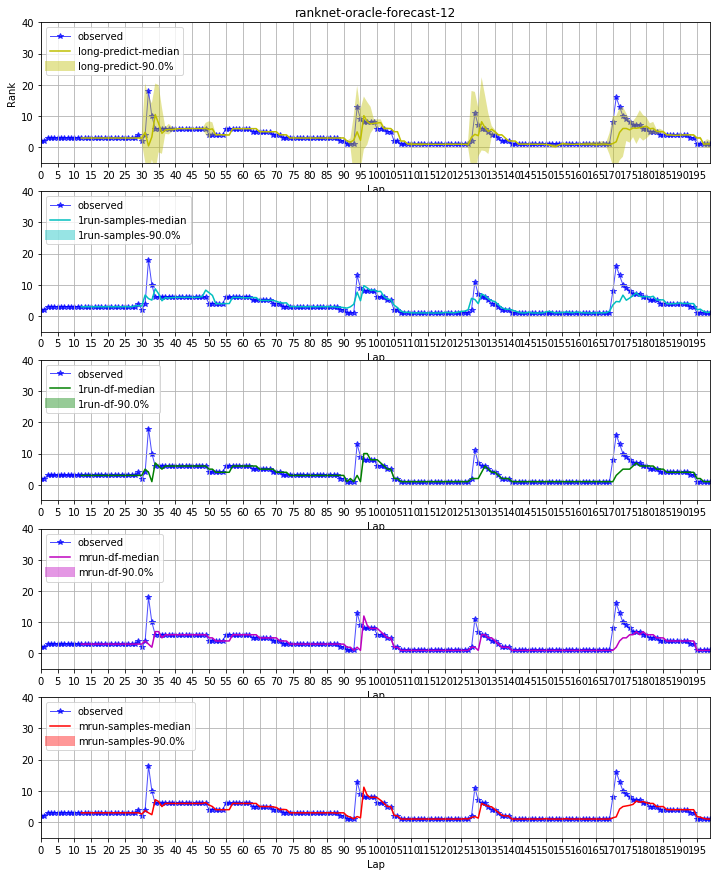

In [39]:
carno=12
tsss, targets = alldata[carno]
targets[1].samples = np.mean(targets[1].samples, axis=0).reshape((1,-1))
plot_forecasts_h(tsss[:5], targets[:5],                  
           'ranknet-oracle-forecast-%d'%carno,
               colors = ['y','c','g','m','r'],
               plabels= ['observed','long-predict','1run-samples','1run-df','mrun-df','mrun-samples'])

In [23]:
def plotoracles(carno):
    #tss_arima, target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
    tsss, targets = alldata[carno]
    
    plot_forecasts_h(tsss[:5], targets[:5],                    
               'ranknet-oracle-forecast-%d'%carno,
                   colors = ['y','c','g','m','r'],
                   plabels= ['observed','long-predict','1run-samples','1run-df','mrun-df','mrun-samples'])

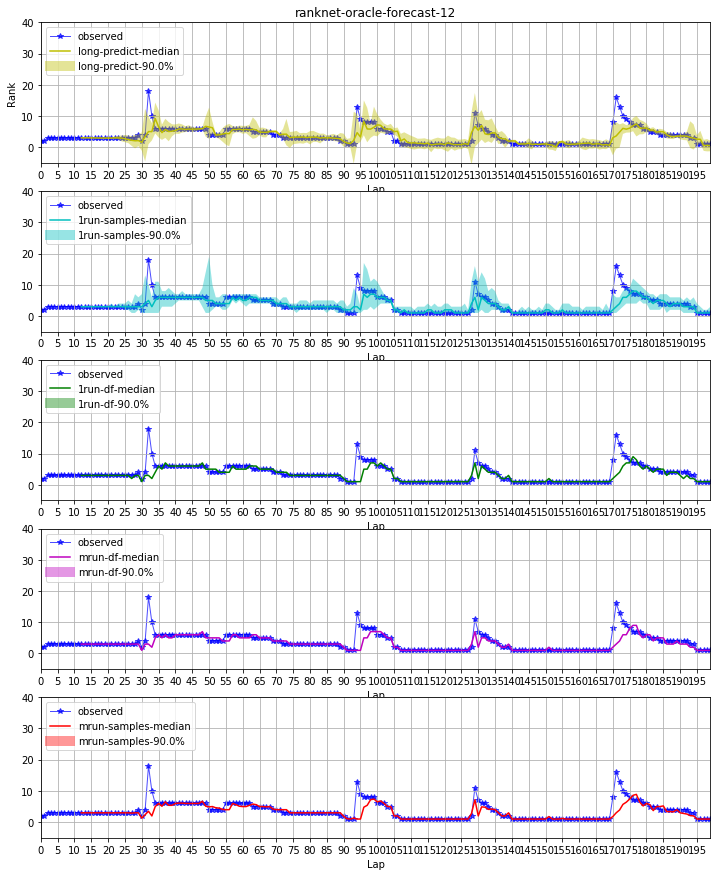

In [24]:
plotoracles(12)

In [26]:
tss, target = alldata[12]


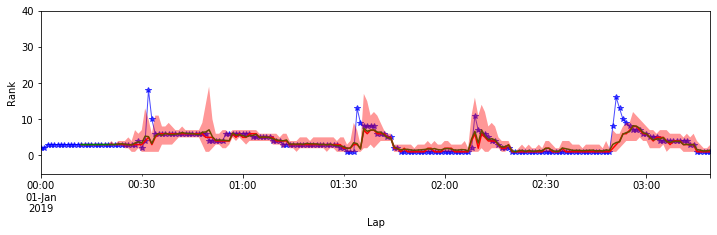

In [27]:
ploth([tss[1]],[target[1]])

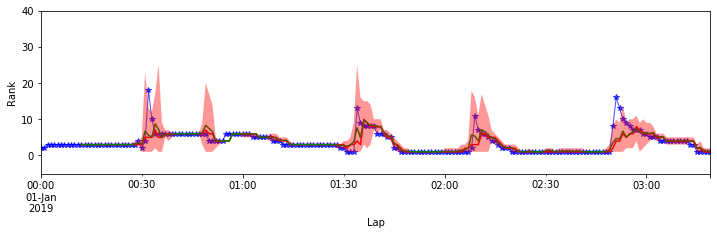

In [47]:
ploth([tss[1]],[target[1]])

### multi draw

In [244]:
with open('Fig3-Indy500-201898.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    alldata = pickle.load(f, encoding='latin1') 

In [245]:
for k in retdata.keys():
    alldata[k] = retdata[k]
    
save_data('Fig3-Indy500-2018-allcar.pickle', alldata)

In [246]:
def fix_target(target):
    """
    nan at the end, remove them, and adjust the start_date
    
    """
    
    rec = target.samples[0,:]
    nanCnt = np.sum(np.isnan(rec))
    
    if nanCnt > 1:
        target.start_date = target.start_date + nanCnt
        target.samples = target.samples[:,:-nanCnt]
        
    return target

In [24]:
def plotcar(carno):
    #tss_arima, target_svr, target_rf,target_arima, target_oracle, target_ranknet_1run = savedata[carno]
    tsss, targets = alldata[carno]
    
    #fix ranknet-mlp
    #nt = fix_target(targets[-1])
    #targets[-1] = nt
    
    plot_forecasts_h(tsss[:5], targets[:5],                    
               'ranknet-rf-rank-forecast-%d'%carno,
                   colors = ['y','c','g','m','r'],
                   plabels= ['observed','SVR','RF','Arima','RrankNet-Oracle','RrankNet-MLP'])

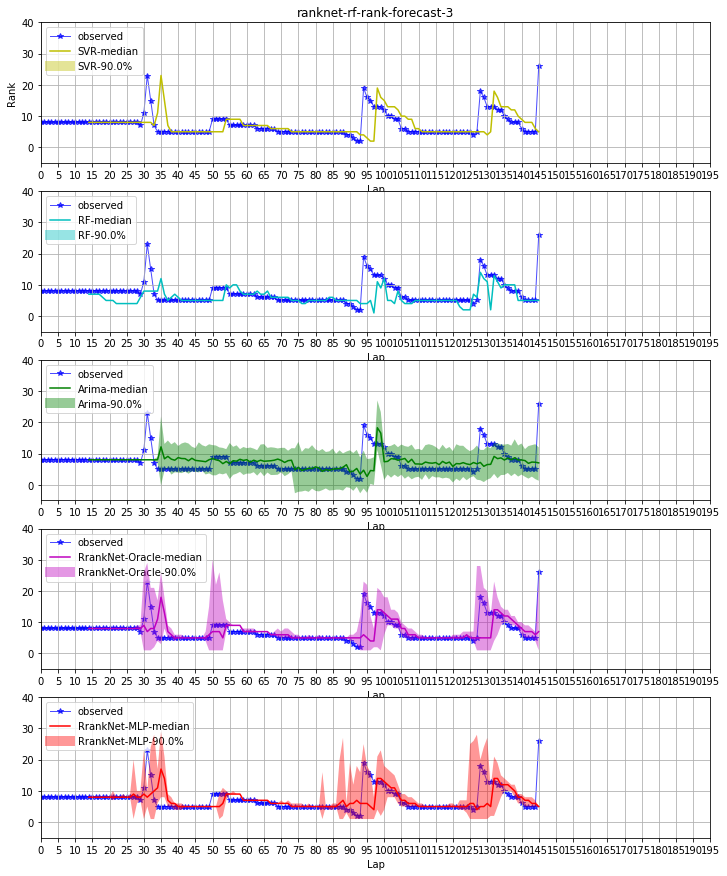

In [25]:
plotcar(3)

In [29]:
plotcar(12)

KeyError: 12

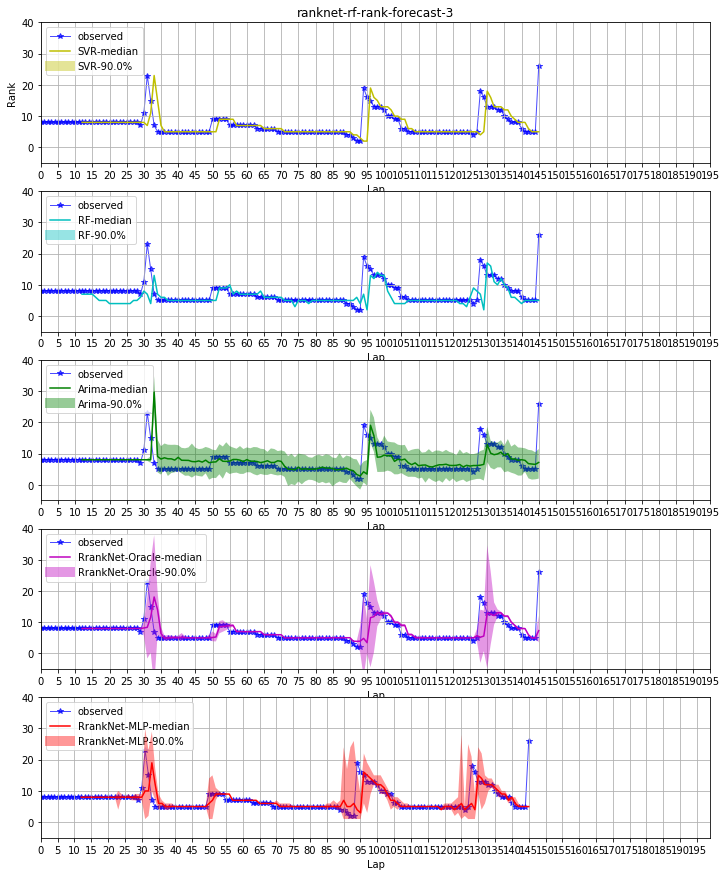

In [29]:
plotcar(3)

In [95]:
alldata

In [119]:
tss, target = alldata[3]

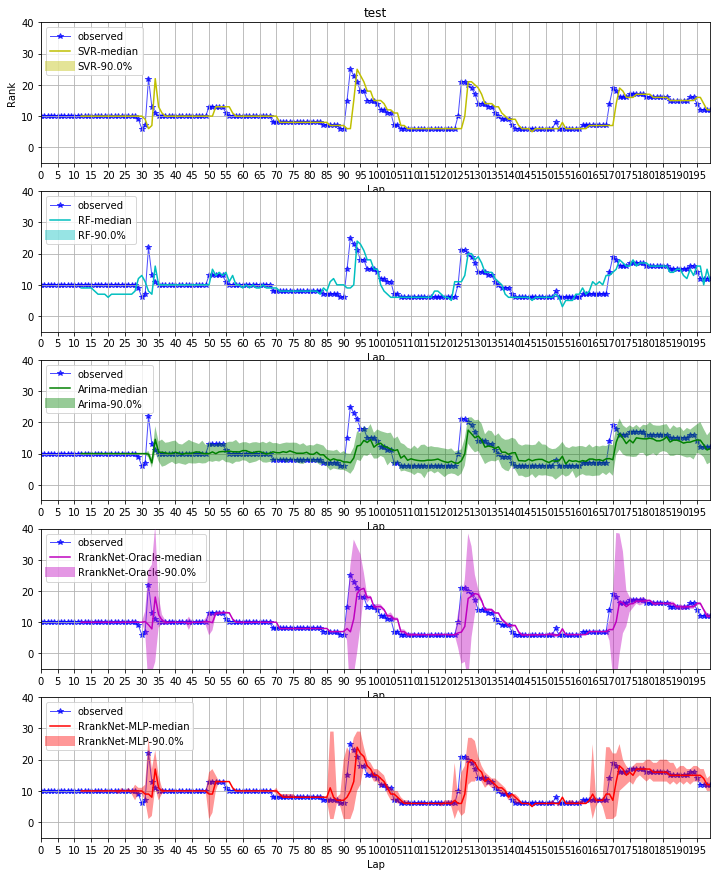

In [100]:
plot_forecasts_h(tss[:5],target[:5],
           'test',
               colors = ['y','c','g','m','r'],
               plabels= ['observed','SVR','RF','Arima','RrankNet-Oracle','RrankNet-MLP'])

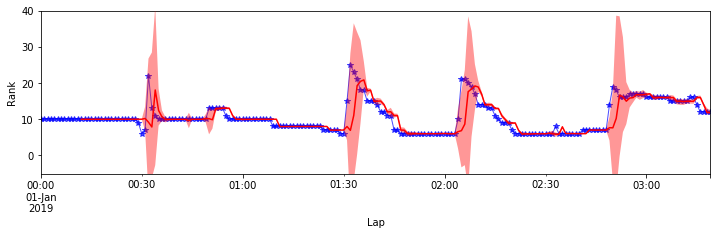

In [96]:
ploth([tss[3]],[target[3]])

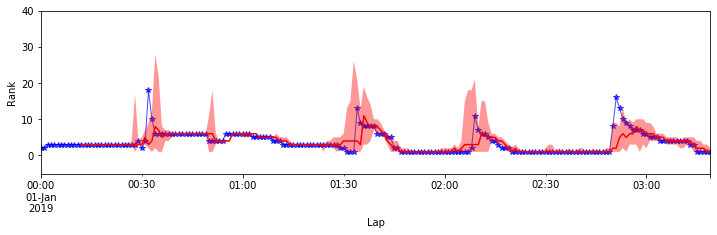

In [300]:
ploth([tss],[target])

In [122]:
nt.samples.shape

(100, 163)

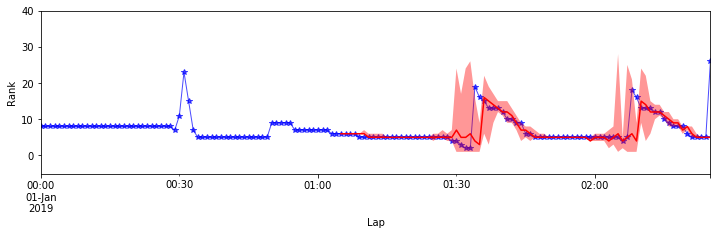

In [187]:
ploth([tss],[target])

In [258]:
with open('Fig3-Indy500-2018-allcar.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    retdata = pickle.load(f, encoding='latin1') 
    
tsss, targets = retdata[13]

In [35]:
tsss, targets = alldata[3]

In [36]:
tss2, target2 = tsss[4], targets[4]
print('tss:', len(tss2), 'target:', target2.samples.shape, 'start:', target2.start_date)

tss: 146 target: (100, 135) start: 2019-01-01 00:11:00


In [37]:
tss2, target2 = tsss[3], targets[3]
print('tss:', len(tss2), 'target:', target2.samples.shape, 'start:', target2.start_date)

tss: 146 target: (100, 135) start: 2019-01-01 00:11:00


In [38]:
target2.samples[:,-20:]

array([[ 6.,  5., 28., ...,  7.,  6.,  1.],
       [ 6., 28.,  5., ...,  6.,  8., 25.],
       [ 5., 17.,  2., ...,  7.,  5.,  1.],
       ...,
       [ 3., 12.,  6., ...,  7.,  1.,  4.],
       [ 8.,  3., 11., ...,  5.,  5.,  4.],
       [ 5.,  2., 14., ...,  8.,  7., 10.]])

In [39]:
tss, target = tsss[0], targets[0]
print('tss:', len(tss), 'target:', target.samples.shape, 'start:', target.start_date)

tss: 146 target: (100, 135) start: 2019-01-01 00:11:00


In [40]:
np.sum(np.isnan(target.samples[0,:]))

3

In [41]:
target.samples[0,:]

array([nan,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  7., 11., 23., 15.,  7.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  9.,  9.,  9.,  9.,  9.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  6.,  6.,  6.,  6.,  6.,  6.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  4.,  4.,  3.,  2.,  2., 19., 16., 15., 13., 13., 13.,
       12., 10., 10.,  9.,  9.,  6.,  6.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        4.,  5., 18., 16., 13., 13., 13., 12., 12., 10.,  9.,  8.,  8.,
        8.,  6.,  5., nan, nan])

In [299]:
target.samples[0,:]

array([nan,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,
        4.,  3.,  3.,  3., 10.,  3.,  3.,  5.,  2.,  5.,  5.,  8.,  5.,
        6.,  6.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        5.,  5.,  6.,  4.,  4.,  4.,  4.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  5.,  4.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  2.,
        3.,  2.,  7., 29., 11.,  4.,  7., 12., 13.,  9.,  8.,  7.,  8.,
        5.,  4.,  5.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  3., 18.,  4.,
        3.,  3.,  2.,  3.,  8.,  1.,  6.,  4.,  4.,  4.,  2.,  2.,  1.,
        1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  4.,  1.,  5.,  9.,  6.,  3.,  7., 12.,  8.,  8.,
        8.,  7.,  6.,  5.,  5.,  5.,  4.,  4.,  3.,  5.,  3.,  3

In [184]:
tss, target = tsss[-1], targets[-1]
print('tss:', len(tss), 'target:', target.samples.shape, 'start:', target.start_date)

tss: 146 target: (100, 135) start: 2019-01-01 00:11:00


In [174]:
target.start_date - target2.start_date

Timedelta('0 days 00:54:00')

In [188]:
retdata.keys()

dict_keys([1, 3, 4, 6, 7, 9, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 59, 60, 64, 66, 88, 98])

In [237]:
testcar=12
samples = ret['pitmodel-RANK-2018-inlap-nopitage'][0][1][testcar]
tss  = ret['pitmodel-RANK-2018-inlap-nopitage'][0][2][testcar]


In [238]:
samples[0,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  2.,
        2.,  2.,  9.,  2.,  2.,  4.,  1.,  4.,  4.,  7.,  4.,  5.,  5.,
        4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  4.,
        5.,  3.,  3.,  3.,  3.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        4.,  4.,  4.,  4.,  4.,  4.,  3.,  4.,  3.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  1.,  2.,  1.,
        6., 28., 10.,  3.,  6., 11., 12.,  8.,  7.,  6.,  7.,  4.,  3.,
        4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2., 17.,  3.,  2.,  2.,
        1.,  2.,  7.,  0.,  5.,  3.,  3.,  3.,  1.,  1.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  3.,  0.,  4.,  8.,  5.,  2.,  6., 11.,  7.,  7.,  7

In [239]:
target.samples[0,:]

array([nan,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,
        4.,  3.,  3.,  3., 10.,  3.,  3.,  5.,  2.,  5.,  5.,  8.,  5.,
        6.,  6.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        5.,  5.,  6.,  4.,  4.,  4.,  4.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  5.,  4.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  2.,
        3.,  2.,  7., 29., 11.,  4.,  7., 12., 13.,  9.,  8.,  7.,  8.,
        5.,  4.,  5.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  3., 18.,  4.,
        3.,  3.,  2.,  3.,  8.,  1.,  6.,  4.,  4.,  4.,  2.,  2.,  1.,
        1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  4.,  1.,  5.,  9.,  6.,  3.,  7., 12.,  8.,  8.,
        8.,  7.,  6.,  5.,  5.,  5.,  4.,  4.,  3.,  5.,  3.,  3

In [240]:
target_ranknet_1run, tss_ranknet_1run = long_predict_bysamples('ranknet-rank', samples, tss)

tss len=34, forecasts len=34
11 44
sampel# x predictlen:  100 2
target samples shape: (100, 189)


In [241]:
target_ranknet_1run.samples[0,:]

array([nan,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,
        4.,  3.,  3.,  3., 10.,  3.,  3.,  5.,  2.,  5.,  5.,  8.,  5.,
        6.,  6.,  5.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        5.,  5.,  6.,  4.,  4.,  4.,  4.,  6.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  5.,  5.,  5.,  5.,  5.,  5.,  4.,  5.,  4.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  2.,
        3.,  2.,  7., 29., 11.,  4.,  7., 12., 13.,  9.,  8.,  7.,  8.,
        5.,  4.,  5.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  3., 18.,  4.,
        3.,  3.,  2.,  3.,  8.,  1.,  6.,  4.,  4.,  4.,  2.,  2.,  1.,
        1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  4.,  1.,  5.,  9.,  6.,  3.,  7., 12.,  8.,  8.,
        8.,  7.,  6.,  5.,  5.,  5.,  4.,  4.,  3.,  5.,  3.,  3

In [251]:
tss13, target13 = retdata[13]

In [253]:
target13[-1].samples[0,:]

array([nan, 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       13., 12., 12., 11., 12., 10., 17., 30., 22., 22., 22., 12., 13.,
        9., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 13., 13.,
       17., 11., 14., 14., 14., 14., 15., 15., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [254]:
target13[-1].start_date

Timestamp('2019-01-01 00:11:00', freq='T')

In [275]:
with open('Fig3-Indy500-2018-allcar.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    retdata = pickle.load(f, encoding='latin1') 
    

In [276]:
for carno in carlist:
    tss13, target13 = retdata[carno]
    nanCnt = np.sum(np.isnan(target13[-1].samples[0,:]))
    nt = target13[-1].samples[:,:-nanCnt+1]
    target13[-1].samples = nt

In [277]:
target13[-1].samples[0,:]

array([nan, 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 22., 24., 26., 32., 30., 30., 31., 26., 26.,
       27., 27., 27., 28., 28., 29., 29., 29., 30.])

In [262]:
tss13, target13 = retdata[13]
nanCnt = np.sum(np.isnan(target13[-1].samples[0,:]))

In [263]:
print(nanCnt)

134


In [267]:
nt = target13[-1].samples[:,-nanCnt-610:-nanCnt+1]

In [279]:
retdata.keys()

dict_keys([1, 3, 4, 6, 7, 9, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 59, 60, 64, 66, 88, 98, 10, 13, 30, 33])

In [269]:
target13[-1].samples = nt

In [270]:
target13[-1].samples[0,:]

array([nan, 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       13., 12., 12., 11., 12., 10., 17., 30., 22., 22., 22., 12., 13.,
        9., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 13., 13.,
       17., 11., 14., 14., 14., 14., 15., 15., 16., 16., 16., 16., 16.,
       16., 16., 16., 16.])

In [271]:
retdata[13][1][-1].samples[0,:]

array([nan, 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       13., 12., 12., 11., 12., 10., 17., 30., 22., 22., 22., 12., 13.,
        9., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 13., 13.,
       17., 11., 14., 14., 14., 14., 15., 15., 16., 16., 16., 16., 16.,
       16., 16., 16., 16.])

In [280]:
save_data('Fig3-Indy500-2018-allcar-fix.pickle', retdata)

In [286]:
target13[-1]

gluonts.model.forecast.SampleForecast(freq="T", info=None, item_id=None, samples=numpy.array([[19.857494444675027, 19.80690273996503], [20.01340861279294, 20.417446322868575], [20.04561178614761, 20.093782827245306], [20.23405385582283, 20.263394407251063], [19.795257147932162, 20.034688740205524], [19.535446099284027, 19.3119247381134], [20.407332293503067, 21.047472707503715], [20.57018130405288, 20.66864358339961], [19.447902503940966, 19.20679180719463], [19.67124671996303, 19.482793976137703], [20.064766093670055, 20.29135969019923], [20.38235793923218, 19.971037813333567], [19.38936025567947, 19.49098898706204], [20.41291640373757, 20.611945878874145], [20.588721998388447, 20.903965328833568], [20.45162587862683, 20.421732994130885], [19.63755732505751, 20.145450781396896], [19.715144966019356, 19.004322505577292], [19.973649817939737, 20.083654864309164], [19.804543535039276, 19.744534245275602], [19.963444105418898, 19.853076714430834], [20.252602027679817, 20.154784891143642],

In [90]:
df = oracle_ret['oracle-RANK-2018-inlap-nopitage'][0][0]

In [92]:
df[df['carno']==3]

,carno,startlap,startrank,endrank,diff,sign,pred_endrank,pred_diff,pred_sign
1,3,10,7.0,7.0,0.0,0,7.0,0.0,0
34,3,11,7.0,7.0,0.0,0,7.0,0.0,0
67,3,12,7.0,7.0,0.0,0,7.0,0.0,0
100,3,13,7.0,7.0,0.0,0,7.0,0.0,0
133,3,14,7.0,7.0,0.0,0,7.0,0.0,0
166,3,15,7.0,7.0,0.0,0,7.0,0.0,0
199,3,16,7.0,7.0,0.0,0,7.0,0.0,0
232,3,17,7.0,7.0,0.0,0,7.0,0.0,0
265,3,18,7.0,7.0,0.0,0,7.0,0.0,0
298,3,19,7.0,7.0,0.0,0,7.0,0.0,0


In [34]:
df = preddf['2018']['svr']
df[df['carno']==3]

,carno,startlap,startrank,endrank,pred_endrank,diff,sign,pred_diff,pred_sign
1,3.0,9.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0
34,3.0,10.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0
67,3.0,11.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0
100,3.0,12.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0
133,3.0,13.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0
166,3.0,14.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0
199,3.0,15.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0
232,3.0,16.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0
265,3.0,17.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0
298,3.0,18.0,7.0,7.0,7.0,0.0,0.0,0.0,0.0
